## Review

Hi Vladimir. Soslan is here. As always, I've added all my comments to new cells with different coloring.

<div class="alert alert-success" role="alert">
  If you did something great I'm using green color for my comment
</div>

<div class="alert alert-warning" role="alert">
If I want to give you advice or think that something can be improved, then I'll use yellow. This is an optional recommendation.
</div>

<div class="alert alert-danger" role="alert">
  If the topic requires some extra work so I can accept it then the color will be red
</div>

You did a nice project. All steps are correct. So, I'm accepting your project. Thank you for your work.

---

The Sure Tomorrow insurance company wants to protect its clients' data. Your task is to develop a data transforming algorithm that would make it hard to recover personal information from the transformed data. Prove that the algorithm works correctly

The data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model.

In [1]:
%%writefile requirements.txt 
watermark
ipython-autotime

Writing requirements.txt


In [2]:
!pip install -r requirements.txt -qq

In [3]:
%load_ext watermark
%load_ext autotime

In [6]:
%watermark -p numpy,scipy,sklearn,seaborn -g

time: 486 µs


<div class="alert alert-warning" role="alert">
I didn't execute upper cells.</div>

## 1. Data downloading

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import OLS
import seaborn as sns
from IPython.display import display, Math
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

time: 103 ms


In [8]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

time: 952 µs


In [9]:
#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

time: 5 ms


In [10]:
data_path = "https://code.s3.yandex.net/datasets/insurance_us.csv"
df = pd.read_csv(data_path)

time: 168 ms


In [11]:
describe_full(df)

,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
Gender,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0,int64,0.0,2,0.004001,0,-2.000784
Age,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0,float64,0.0,46,0.515148,12,-0.297665
Salary,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0,float64,0.0,524,-0.036723,14,0.021468
Family members,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0,int64,0.0,7,0.898297,39,0.715275
Insurance benefits,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0,int64,0.0,6,3.845707,141,18.163968


time: 96.4 ms


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Gender                5000 non-null int64
Age                   5000 non-null float64
Salary                5000 non-null float64
Family members        5000 non-null int64
Insurance benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
time: 5.92 ms


In [13]:
df.isna().sum()

Gender                0
Age                   0
Salary                0
Family members        0
Insurance benefits    0
dtype: int64

time: 5.78 ms


In [14]:
df.head()

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


time: 9.38 ms


In [15]:
df = df.drop_duplicates().reset_index()

time: 7.55 ms


In [16]:
df["Age"] = df["Age"].astype("int64")

time: 2.73 ms


In [17]:
features = ['Gender', 'Age', 'Salary', 'Family members']
target = 'Insurance benefits'

time: 690 µs


In [18]:
df[target].unique()

array([0, 1, 2, 3, 5, 4])

time: 3.68 ms


most important features by 

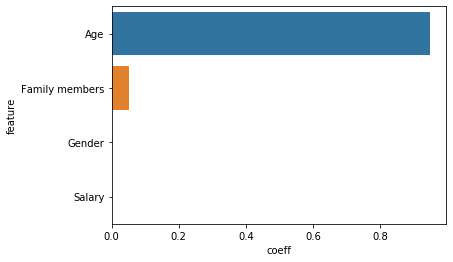

time: 233 ms


In [19]:
X, y = df[features].values,df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)
rfc = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = rfc.predict(X_test)
df_feature_importances = pd.DataFrame(((zip(features, rfc.feature_importances_)))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

<div class="alert alert-success" role="alert">
Good start. Data was opened and examined correctly.</div>


## 2. Multiplication of matrices

In this task, you can write formulas in *Jupyter Notebook.*

To write the formula in-between the text, frame it with dollar signs \\$; if it should be outside the text —  with double signs \\$\\$. These formulas are written in markup language *LaTeX.* 

For example, we wrote down linear regression formulas. You can copy and edit them to solve the task.

You don't have to use *LaTeX*.

Denote:

- $X$ — feature matrix (zero column consists of unities)

- $y$ — target vector

- $P$ — matrix by which the features are multiplied

- $w$ — linear regression weight vector (zero element is equal to the shift)

Predictions:

$$
a = Xw
$$

Training objective:

$$
\min_w d_2(Xw, y)
$$

Training formula:

$$
w = (X^T X)^{-1} X^T y
$$

Our main goal is depersonalized data(and sub-goal is min distance between Xw and y as linear regression task). According:

$X'=Xs$ 

$w = (X^T X)^{-1} X^T y$

$w' = (X'^T X')^{-1} X'^T y = ((Xs)^{T}(Xs))^{-1}(Xs)^{T}y = (s^{T}X^{T}Xs)^{-1}s^{T}X^{T}y = s^{-1}(X^{T}X)^{-1}s^{T^{-1}}s^{T}X^{T}y$, where s - random salt and $(s^T)^{-1}s^{T} = E$

therefore:
$w'=s^{-1}(X^{T}X)^{-1}s^{T^{-1}}s^{T}X^{T}y=s^{-1}w$  
and finally:
$a'= Xsw' = Xss^{-1}w = XEw = Xw = a$

QED


<div class="alert alert-success" role="alert">
Excellent. The proof is clear and mathematically rigorous.</div>


## 3. Transformation algorithm

$X_s = XS$,

$X = X_sS^{-1}$

Let's check it on our data

In [20]:
X.mean(), X.std()

(9982.134413038993, 17975.984686392443)

time: 3.78 ms


In [21]:
coeff_var = X.mean()/X.std()
coeff_var

0.5553039005754896

time: 3.67 ms


In [22]:
mu = np.random.randint(100,200)
sigma = mu/coeff_var
s = np.random.normal(mu, sigma, size=(X.shape[1], X.shape[1])).astype('int64')
s

array([[-151,  237,  226,  425],
       [  -6,    8,   -4, -100],
       [-559,  409,  373, -263],
       [  34,  -50,  -40, -430]])

time: 4.25 ms


In [23]:
np.allclose(np.rint(X @ s @ np.linalg.inv(s)), X)

True

time: 33.9 ms


## 4. Algorithm test

In [24]:
class LinearRegressionImpl:
    def fit(self, X, y):
        n_samples = len(y)
        X = np.hstack((np.ones((n_samples, 1)), X))
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.w0 = w[0]
        self.w = w[1:]
        return self
 
    def predict(self, X):
        return X @ self.w + self.w0     

time: 1.73 ms


numpy based implementation without random salt:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)
lr = LinearRegressionImpl().fit(X_train, y_train)
y_pred = lr.predict(X_test)
display(Math(r"$R_2={}$".format(r2_score(y_test, y_pred))))

<IPython.core.display.Math object>

time: 106 ms


numpy based implementation with random salt:

In [26]:
coeff_var = X.mean()/X.std()
mu = np.random.randint(100,200)
sigma = mu/coeff_var
s = np.random.normal(mu, sigma, size=(X.shape[1], X.shape[1])).astype('int64')

time: 2.08 ms


In [27]:
X_s = X@s

time: 912 µs


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=seed_value)
lr = LinearRegressionImpl().fit(X_train, y_train)
y_pred = lr.predict(X_test)
display(Math(r"$R_2={}$".format(r2_score(y_test, y_pred))))

<IPython.core.display.Math object>

time: 172 ms


sklearn LR without random salt:

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
display(Math(r"$R_2={}$".format(r2_score(y_test, y_pred))))

<IPython.core.display.Math object>

time: 194 ms


sklearn LR with random salt:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=seed_value)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
display(Math(r"$R_2={}$".format(r2_score(y_test, y_pred))))

<IPython.core.display.Math object>

time: 80.2 ms


as we see, we proved our transformation algorithm and also checked it on linear regression model, all of the results($R_2$) are pretty equal

<div class="alert alert-success" role="alert">
Algo and testing are correct.</div>

## Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  Step 1 performed: the data was downloaded
- [ ]  Step 2 performed: the answer to the matrix multiplication problem was provided
    - [ ]  The correct answer was chosen
    - [ ]  The choice was justified
- [ ]  Step 3 performed: the transform algorithm was proposed
    - [ ]  The algorithm was described
    - [ ]  The algorithm was justified
- [ ]  Step 4 performed: the algorithm was tested
    - [ ]  The algorithm was realized
    - [ ]  Model quality was assessed before and after the transformation